This project aims to answer to the following questions:
- What attributes contribute the most for a telephone selling call to be successful (that is, to lead the client subscribe a term deposit)?
- What is the profile of the most subscribing clients?

In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from time import strptime
from datetime import datetime

In [3]:
DATA_PATH = "../data/"

In [4]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Importing data

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, "bank-additional-full.csv"), sep=";")

In [6]:
df.shape

(41188, 22)

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
1,57,services,married,high.school,unknown,no,no,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
2,37,services,married,high.school,no,yes,no,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
4,56,services,married,high.school,no,no,yes,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no


## 2. Analysis against the target

###  2.1 Target

Is it balanced or unbalanced?

<AxesSubplot:xlabel='y', ylabel='count'>

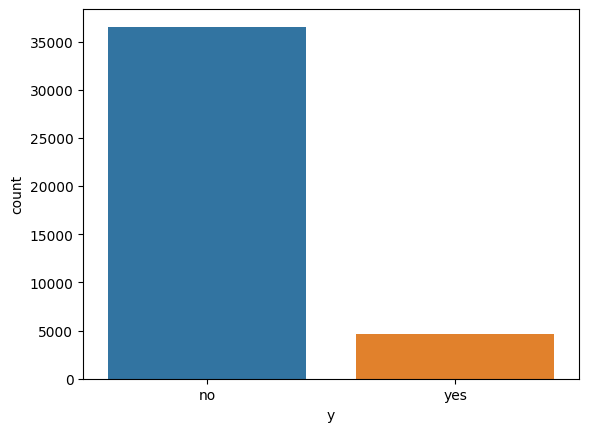

In [8]:
sns.countplot(data=df, x="y")

In [9]:
df["y"].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [10]:
len(df[df["y"] == "yes"]) / len(df)

0.11265417111780131

We see that the target has some imbalancement, where the positive target represents 11% of the dataset.

### 2.2 Bank client data

### Time relationship

According to the UCI Repository page, the dataset is ordered by date from May 2008 to November 2010 (roughly 2 years and 6 months = 30 months).

I've added manually the field `year`, assuming that it is ordered by date.

First, we convert the `month` abbreviated string to the respective number.

In [11]:
df["month_nb"] = df["month"].apply(lambda x : strptime(x,'%b').tm_mon)

In [12]:
df[["month", "month_nb"]].drop_duplicates()

,month,month_nb
0,may,5
7763,jun,6
12137,jul,7
18822,aug,8
23997,oct,10
24064,nov,11
27680,dec,12
27690,mar,3
27972,apr,4
37887,sep,9


Second, let's join the year and the month

In [13]:
df["anomes"] = (df["year"].astype(str) + df["month_nb"].astype(str).str.zfill(2)).astype(int)

How many of each reference do we have on the dataset? Are there missing references?

In [14]:
df["anomes"].value_counts().sort_index()

200805    7763
200806    4374
200807    6685
200808    5175
200810      67
200811    3616
200812      10
200903     282
200904    2458
200905    5794
200906     715
200907     178
200908     770
200909     267
200910     447
200911     357
200912     172
201003     264
201004     174
201005     212
201006     229
201007     311
201008     233
201009     303
201010     204
201011     128
Name: anomes, dtype: int64

In [15]:
df["month"].value_counts().sort_index()

apr     2632
aug     6178
dec      182
jul     7174
jun     5318
mar      546
may    13769
nov     4101
oct      718
sep      570
Name: month, dtype: int64

Conclusions:
1. We can see that the biggest quantity of records are found in the year 2008.
2. We didn't have any call for the months 200809, 200901, 200902, 201001, 201002.
3. We had very few records in 200810, 200812.

What is the proportion of positive and negative examples in each anomes?

In [16]:
df.groupby(["anomes"]).apply(lambda x : len(x[x["y"] == "yes"]) / len(x)).sort_index()

anomes
200805   0.031
200806   0.043
200807   0.061
200808   0.052
200810   0.627
200811   0.053
200812   0.100
200903   0.447
200904   0.180
200905   0.090
200906   0.369
200907   0.371
200908   0.343
200909   0.397
200910   0.403
200911   0.471
200912   0.512
201003   0.568
201004   0.557
201005   0.575
201006   0.467
201007   0.566
201008   0.515
201009   0.495
201010   0.456
201011   0.453
dtype: float64

We see an increasing proportion, that is, we have more positive examples among the years with less examples.

In [17]:
df_aux = df.copy()
df_aux["data"] = df_aux["anomes"].apply(lambda x : datetime.strptime(str(x), '%Y%m'))

In [18]:
df_aux[["anomes", "data"]].head()

,anomes,data
0,200805,2008-05-01
1,200805,2008-05-01
2,200805,2008-05-01
3,200805,2008-05-01
4,200805,2008-05-01


In [19]:
df_aux = df_aux.groupby(["data"])["y"].value_counts().rename("counts").to_frame().reset_index()

In [20]:
df_plot = pd.pivot_table(df_aux, values="counts", index="data", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,data,no,yes
0,2008-05-01,7523,240
1,2008-06-01,4186,188
2,2008-07-01,6278,407
3,2008-08-01,4904,271
4,2008-10-01,25,42


<AxesSubplot:xlabel='data'>

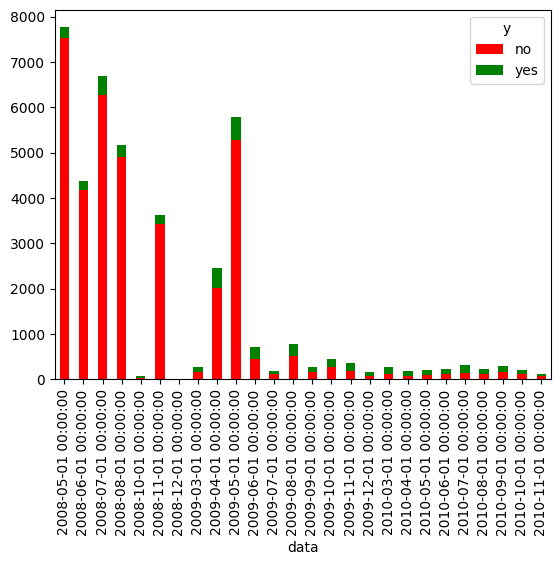

In [21]:
df_plot.plot(kind='bar', x="data", stacked=True, color=['red', 'green'])

We can see that the quantity of subscriptions is approximately equal among the months, regadless of the total of calls. That might mean an increase on the quality of the service and offers from 2009 on.

### Age

Is there any tendency in age related to subscribe or not to a term deposit?

In [22]:
df.groupby("y")["age"].mean()

y
no    39.911
yes   40.913
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

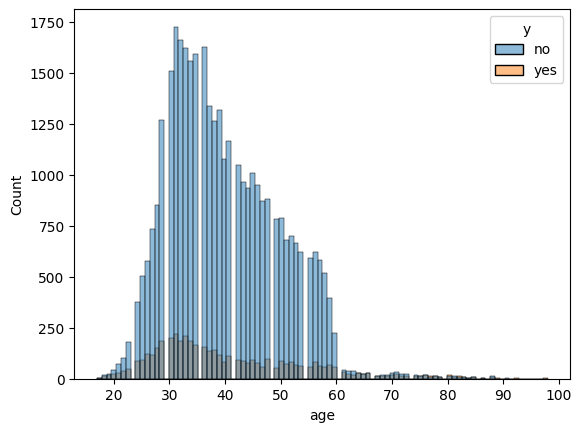

In [23]:
sns.histplot(data=df, x="age", hue="y")

<AxesSubplot:xlabel='y', ylabel='age'>

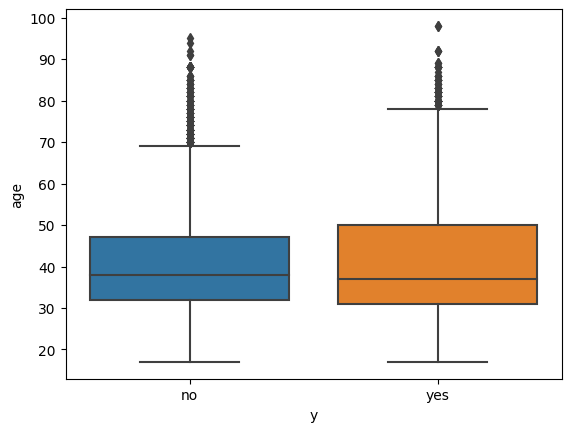

In [24]:
sns.boxplot(data=df, x="y", y="age")

It seams not to have any tendency in subscribing according to the age of the client.

Even though, the most subscribers we have are in average 40 years old.

### Marital status

Is there any tendency in marital status related to subscribe or not to a term deposit?

In [25]:
df["marital"].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [26]:
df_aux = df.groupby(["marital"])["y"].value_counts().rename("counts").to_frame().reset_index()

In [27]:
df_plot = pd.pivot_table(df_aux, values="counts", index="marital", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,marital,no,yes
0,divorced,4136,476
1,married,22396,2532
2,single,9948,1620
3,unknown,68,12


<AxesSubplot:xlabel='marital'>

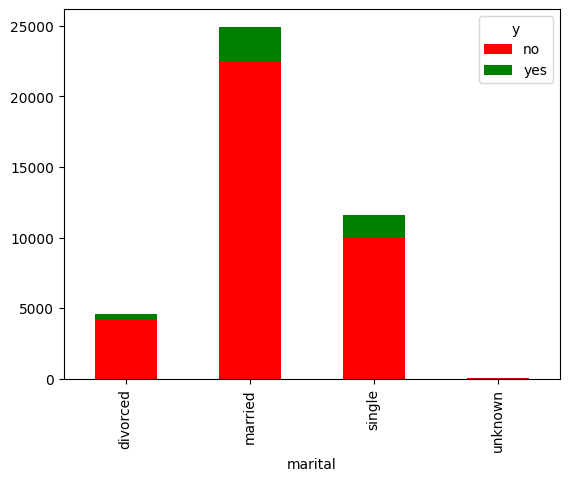

In [28]:
df_plot.plot(kind='bar', x="marital", stacked=True, color=['red', 'green'])

In [29]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["marital", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,marital,no,yes,%yes
3,unknown,68,12,0.150
2,single,9948,1620,0.140
0,divorced,4136,476,0.103
1,married,22396,2532,0.102


We've got bigger percentages for single people (for the unknown category, we don't have enough samples to statistically say it's big).

### Job

Is there any tendency in job related to subscribe or not to a term deposit?

In [30]:
df["job"].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [31]:
df_aux = df.groupby(["job"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="job", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,job,no,yes
0,admin.,9070,1352
1,blue-collar,8616,638
2,entrepreneur,1332,124
3,housemaid,954,106
4,management,2596,328


<AxesSubplot:xlabel='job'>

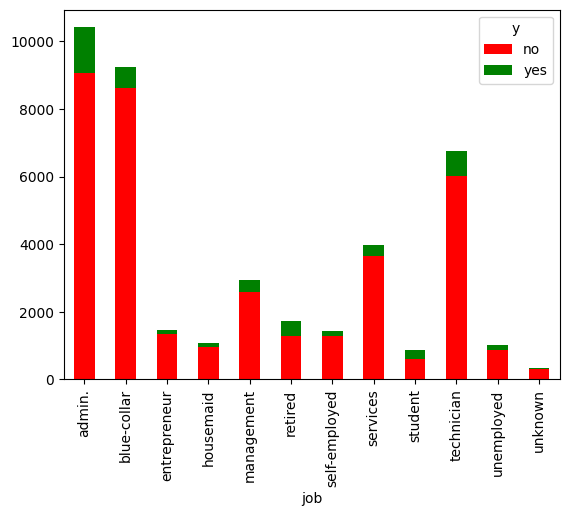

In [32]:
df_plot.plot(kind='bar', x="job", stacked=True, color=['red', 'green'])

In [33]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["job", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,job,no,yes,%yes
8,student,600,275,0.314
5,retired,1286,434,0.252
10,unemployed,870,144,0.142
0,admin.,9070,1352,0.130
4,management,2596,328,0.112
11,unknown,293,37,0.112
9,technician,6013,730,0.108
6,self-employed,1272,149,0.105
3,housemaid,954,106,0.100
2,entrepreneur,1332,124,0.085


We've got bigger percentages for students and retired people.

### Education

Is there any tendency in education related to subscribe or not to a term deposit?

In [34]:
df["education"].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [35]:
df_aux = df.groupby(["education"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="education", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,education,no,yes
0,basic.4y,3748,428
1,basic.6y,2104,188
2,basic.9y,5572,473
3,high.school,8484,1031
4,illiterate,14,4


<AxesSubplot:xlabel='education'>

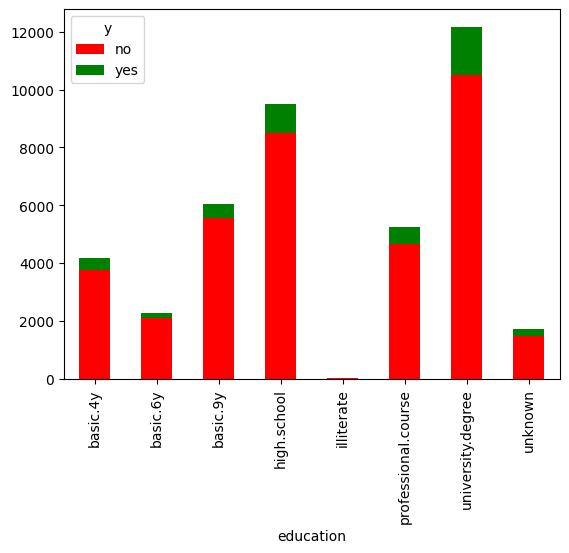

In [36]:
df_plot.plot(kind='bar', x="education", stacked=True, color=['red', 'green'])

In [37]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["education", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,education,no,yes,%yes
4,illiterate,14,4,0.222
7,unknown,1480,251,0.145
6,university.degree,10498,1670,0.137
5,professional.course,4648,595,0.113
3,high.school,8484,1031,0.108
0,basic.4y,3748,428,0.102
1,basic.6y,2104,188,0.082
2,basic.9y,5572,473,0.078


We've got more subscriptions for people with university degree and high school.

### Default

A default occurs when a borrower stops making the required payments on a debt.

In [38]:
df["default"].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [39]:
df_aux = df.groupby(["default"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="default", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,default,no,yes
0,no,28391.000,4197.000
1,unknown,8154.000,443.000
2,yes,3.000,NaN


<AxesSubplot:xlabel='default'>

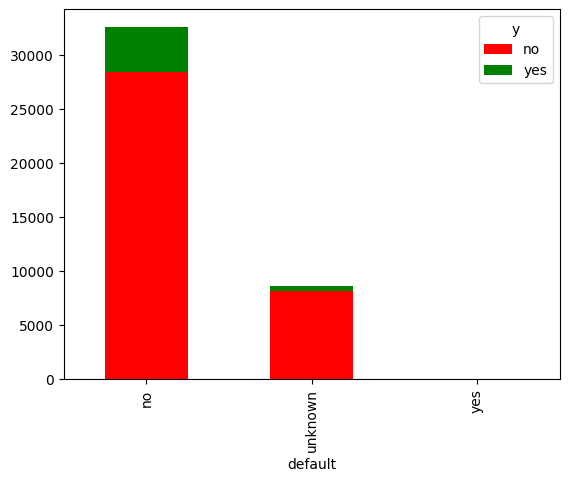

In [40]:
df_plot.plot(kind='bar', x="default", stacked=True, color=['red', 'green'])

In [41]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["default", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,default,no,yes,%yes
0,no,28391.000,4197.000,0.129
1,unknown,8154.000,443.000,0.052
2,yes,3.000,NaN,NaN


As expected, the most part of the public subscribing a term deposit doesn't default, which means they have means to invest.

It is curious that 12% of the public had subscribed even having default.

In [42]:
df

,age,job,marital,education,default,housing,loan,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,month_nb,anomes
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,5,200805
1,57,services,married,high.school,unknown,no,no,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,5,200805
2,37,services,married,high.school,no,yes,no,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,5,200805
3,40,admin.,married,basic.6y,no,no,no,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,5,200805
4,56,services,married,high.school,no,no,yes,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,5,200805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,2010,fri,334,1,999,0,nonexistent,-1.100,94.767,-50.800,1.028,4963.600,yes,11,201011
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,2010,fri,383,1,999,0,nonexistent,-1.100,94.767,-50.800,1.028,4963.600,no,11,201011
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,2010,fri,189,2,999,0,nonexistent,-1.100,94.767,-50.800,1.028,4963.600,no,11,201011
41186,44,technician,married,professional.course,no,no,no,cellular,nov,2010,fri,442,1,999,0,nonexistent,-1.100,94.767,-50.800,1.028,4963.600,yes,11,201011


### Housing

A housing loan is a sum of money borrowed from a financial institution or bank to purchase a house.

In [43]:
df["housing"].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [44]:
df_aux = df.groupby(["housing"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="housing", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,housing,no,yes
0,no,16596,2026
1,unknown,883,107
2,yes,19069,2507


<AxesSubplot:xlabel='housing'>

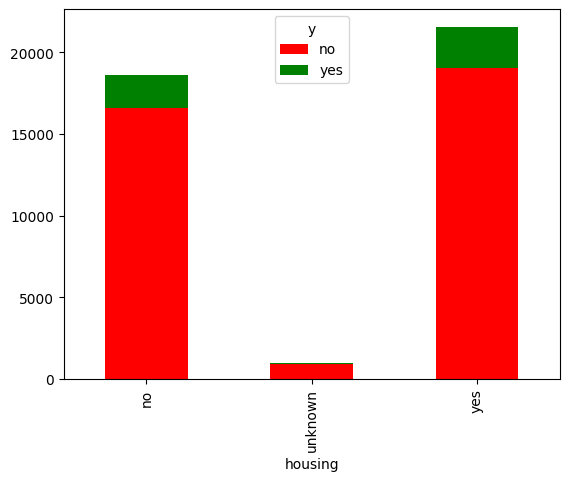

In [45]:
df_plot.plot(kind='bar', x="housing", stacked=True, color=['red', 'green'])

In [46]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["housing", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,housing,no,yes,%yes
2,yes,19069,2507,0.116
0,no,16596,2026,0.109
1,unknown,883,107,0.108


In [47]:
df["housing"].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [48]:
df_aux = df.groupby(["housing"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="housing", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,housing,no,yes
0,no,16596,2026
1,unknown,883,107
2,yes,19069,2507


<AxesSubplot:xlabel='housing'>

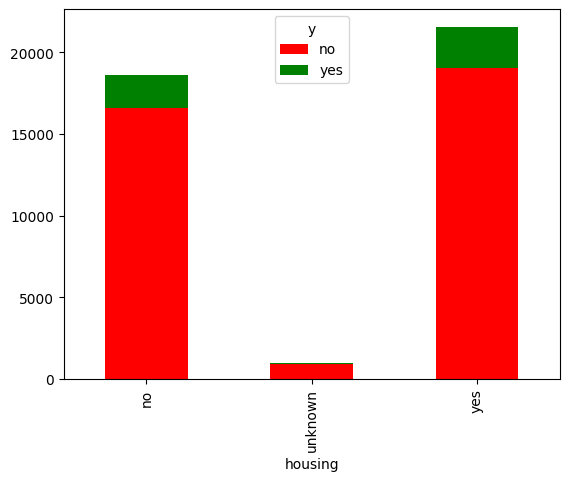

In [49]:
df_plot.plot(kind='bar', x="housing", stacked=True, color=['red', 'green'])

No tendency observed in having a house loan and subscribing.

### Loan

That means if the person has a personal loan.

In [50]:
df["loan"].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [51]:
df_aux = df.groupby(["loan"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="loan", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,loan,no,yes
0,no,30100,3850
1,unknown,883,107
2,yes,5565,683


<AxesSubplot:xlabel='loan'>

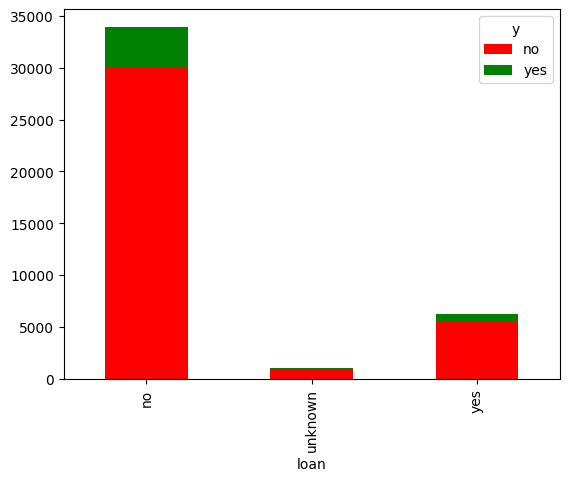

In [52]:
df_plot.plot(kind='bar', x="loan", stacked=True, color=['red', 'green'])

In [53]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["loan", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,loan,no,yes,%yes
0,no,30100,3850,0.113
2,yes,5565,683,0.109
1,unknown,883,107,0.108


No tendency observed in having a personal loan and subscribing.

### 2.2 Related with the last contact of the current campaign

### Contact

Meaning: contact communication type (categorical: 'cellular','telephone') 

In [54]:
df["contact"].value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

In [55]:
df_aux = df.groupby(["contact"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="contact", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,contact,no,yes
0,cellular,22291,3853
1,telephone,14257,787


<AxesSubplot:xlabel='contact'>

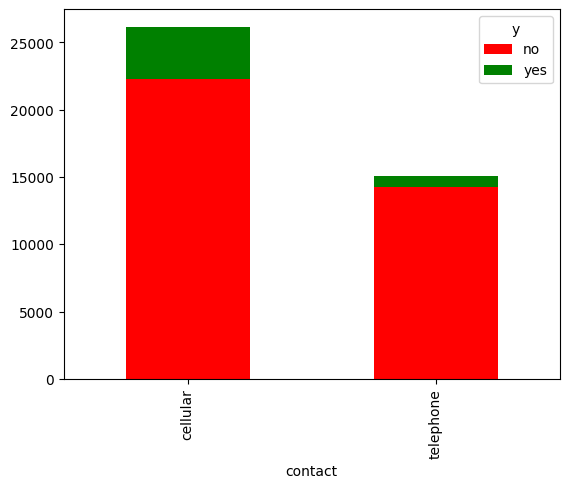

In [56]:
df_plot.plot(kind='bar', x="contact", stacked=True, color=['red', 'green'])

In [57]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["contact", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,contact,no,yes,%yes
0,cellular,22291,3853,0.147
1,telephone,14257,787,0.052


We see that calling by cellular has more success on subscription than calling by telephone.

Is there any change in behaviour on the contact mean through time?

In [58]:
df_aux = df.groupby(["anomes"])["contact"].value_counts().rename("counts").to_frame().reset_index()
df_aux["data"] = df_aux["anomes"].apply(lambda x : datetime.strptime(str(x), '%Y%m'))
df_aux.head()

,anomes,contact,counts,data
0,200805,telephone,7763,2008-05-01
1,200806,telephone,4374,2008-06-01
2,200807,cellular,5696,2008-07-01
3,200807,telephone,989,2008-07-01
4,200808,cellular,5028,2008-08-01


<AxesSubplot:xlabel='data', ylabel='counts'>

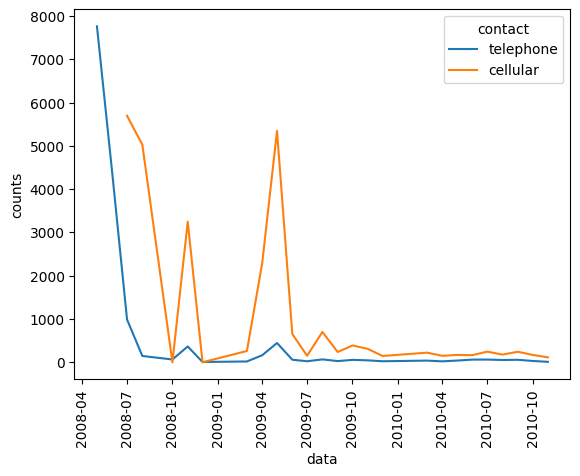

In [59]:
plt.xticks(rotation=90)
sns.lineplot(data=df_aux, x="data", y="counts", hue="contact")

So, through time we see a bigger interest in calling by cellular than by telephone.

### Month

Is there any seasonality in the month of the call?

Meaning: last contact month of year

In [60]:
df["month"].value_counts().sort_values(ascending=False)

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

For any reason, we get twice the calls in `May` with respect to `July`, and very little in `September`, `October`, `March` and `December`.

In [61]:
df_aux = df["month"].value_counts().sort_values(ascending=False).rename("nb of calls").to_frame().reset_index().rename(columns={"index":"month"})

In [62]:
df_aux

,month,nb of calls
0,may,13769
1,jul,7174
2,aug,6178
3,jun,5318
4,nov,4101
5,apr,2632
6,oct,718
7,sep,570
8,mar,546
9,dec,182


Text(0.5, 1.0, 'Number os calls by month')

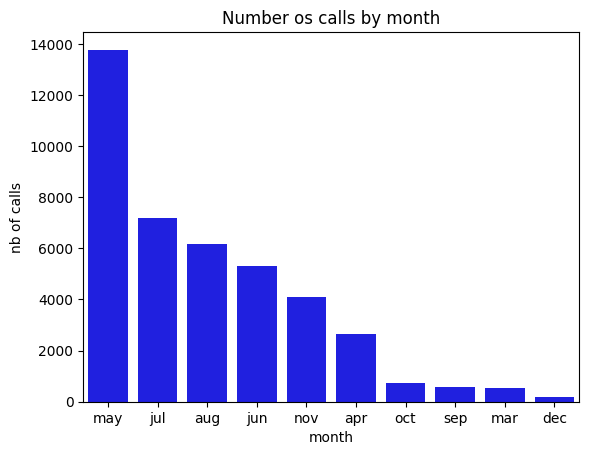

In [63]:
sns.barplot(data=df_aux, x="month", y="nb of calls", color="blue").set_title("Number os calls by month")

Now, looking by proportion of subscriptions

In [64]:
df_aux = df.groupby(["month"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="month", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,month,no,yes
0,apr,2093,539
1,aug,5523,655
2,dec,93,89
3,jul,6525,649
4,jun,4759,559


<AxesSubplot:xlabel='month'>

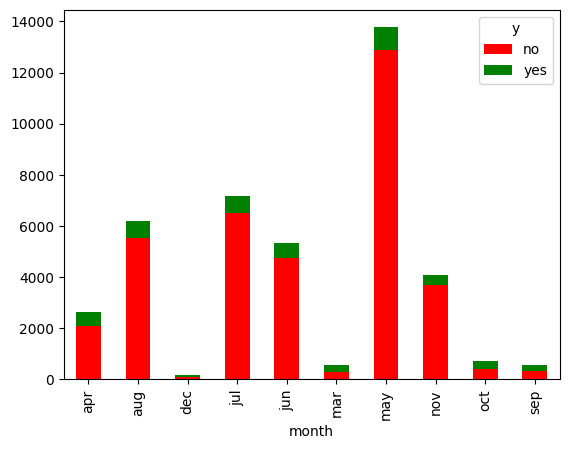

In [65]:
df_plot.plot(kind='bar', x="month", stacked=True, color=['red', 'green'])

In [66]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["month", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,month,no,yes,%yes
5,mar,270,276,0.505
2,dec,93,89,0.489
9,sep,314,256,0.449
8,oct,403,315,0.439
0,apr,2093,539,0.205
1,aug,5523,655,0.106
4,jun,4759,559,0.105
7,nov,3685,416,0.101
3,jul,6525,649,0.090
6,may,12883,886,0.064


In [67]:
may = (12883 + 886)
mar = (270 + 276)
(may - mar) / mar

24.21794871794872

In March we've got good success by converting more than 50% of the calls.

The worst month was May, in which we converted only 6% of the calls, and we did ~24 times more calls and converted only ~6% of them.

### Day of week

Is there any seasonality in the day of week of the call?

Meaning: last contact day of the week

In [68]:
df["day_of_week"].value_counts().sort_values(ascending=False)

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

There's almost no difference in quantity of calls among the days of week. Note that there are only calls in the business days.

In [69]:
df_aux = df["day_of_week"].value_counts().sort_values(ascending=False).rename("nb of calls").to_frame().reset_index().rename(columns={"index":"day_of_week"})

In [70]:
df_aux

,day_of_week,nb of calls
0,thu,8623
1,mon,8514
2,wed,8134
3,tue,8090
4,fri,7827


Text(0.5, 1.0, 'Number os calls by day of week')

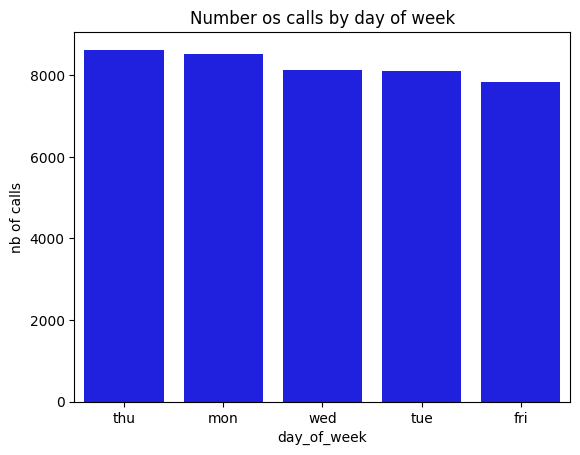

In [71]:
sns.barplot(data=df_aux, x="day_of_week", y="nb of calls", color="blue").set_title("Number os calls by day of week")

Now, looking by proportion of subscriptions

In [72]:
df_aux = df.groupby(["day_of_week"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="day_of_week", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,day_of_week,no,yes
0,fri,6981,846
1,mon,7667,847
2,thu,7578,1045
3,tue,7137,953
4,wed,7185,949


<AxesSubplot:xlabel='day_of_week'>

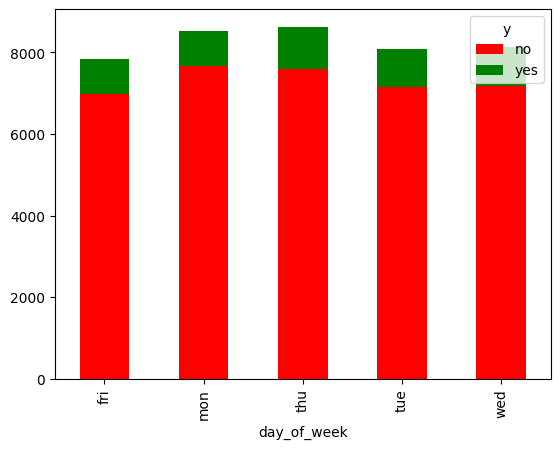

In [73]:
df_plot.plot(kind='bar', x="day_of_week", stacked=True, color=['red', 'green'])

In [74]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["day_of_week", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False)

y,day_of_week,no,yes,%yes
2,thu,7578,1045,0.121
3,tue,7137,953,0.118
4,wed,7185,949,0.117
0,fri,6981,846,0.108
1,mon,7667,847,0.099


Almost the same subscription rate in each day of week.

### Duration

Is there any tendency in the duration of the call (in seconds) related to subscribe or not to a term deposit?

**Note:** the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model (note from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

In [75]:
df.groupby("y")["duration"].mean()

y
no    220.845
yes   553.191
Name: duration, dtype: float64

<AxesSubplot:xlabel='duration', ylabel='Count'>

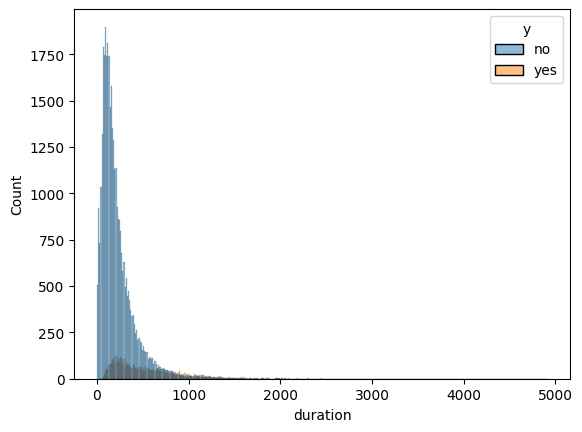

In [76]:
sns.histplot(data=df, x="duration", hue="y")

<AxesSubplot:xlabel='y', ylabel='duration'>

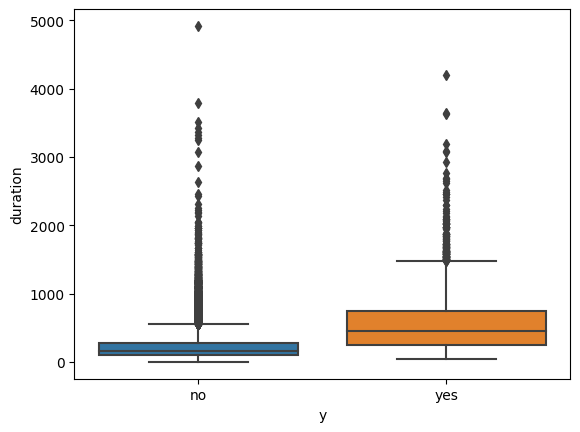

In [77]:
sns.boxplot(data=df, x="y", y="duration")

It's clear (and reasonable) that larger calls lead to more subscriptions than smaller ones, which indicates more negotiation with the client before the product subscription.

Even though, we cannot use that information for prediction, because we do'nt have the duration of the call before calling the client.

### 2.3 Other attributes

### Campaign

Meaning: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Is there any relationship between the number of contacts made and subscribing?

**Note:** doesn't seem like an interesting variable for a predictive model

In [78]:
df["campaign"].value_counts().sort_index()

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
15       51
16       51
17       58
18       33
19       26
20       30
21       24
22       17
23       16
24       15
25        8
26        8
27       11
28        8
29       10
30        7
31        7
32        4
33        4
34        3
35        5
37        1
39        1
40        2
41        1
42        2
43        2
56        1
Name: campaign, dtype: int64

In [79]:
df_aux = df.groupby(["campaign"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="campaign", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,campaign,no,yes
0,1,15342.000,2300.000
1,2,9359.000,1211.000
2,3,4767.000,574.000
3,4,2402.000,249.000
4,5,1479.000,120.000


<AxesSubplot:xlabel='campaign'>

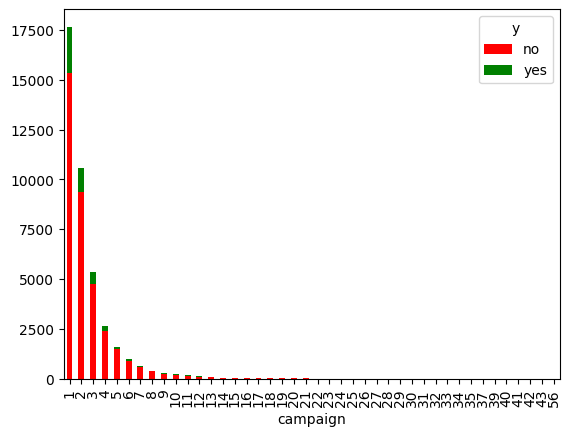

In [80]:
df_plot.plot(kind='bar', x="campaign", stacked=True, color=['red', 'green'])

In [81]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["campaign", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False).fillna(0)

y,campaign,no,yes,%yes
0,1,15342.000,2300.000,0.130
1,2,9359.000,1211.000,0.115
2,3,4767.000,574.000,0.107
3,4,2402.000,249.000,0.094
5,6,904.000,75.000,0.077
4,5,1479.000,120.000,0.075
16,17,54.000,4.000,0.069
10,11,165.000,12.000,0.068
22,23,15.000,1.000,0.062
6,7,591.000,38.000,0.060


We get > 10% of subscription for more than 3 past calls.

### Passed days from the last call

In [82]:
df_aux = df.copy()
df_aux.loc[df_aux["pdays"] == 999, "pdays"] = np.nan

In [83]:
df_aux["pdays"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
41183   NaN
41184   NaN
41185   NaN
41186   NaN
41187   NaN
Name: pdays, Length: 41188, dtype: float64

In [84]:
df_aux.groupby("y")["pdays"].mean()

y
no    6.193
yes   5.913
Name: pdays, dtype: float64

<AxesSubplot:xlabel='y', ylabel='pdays'>

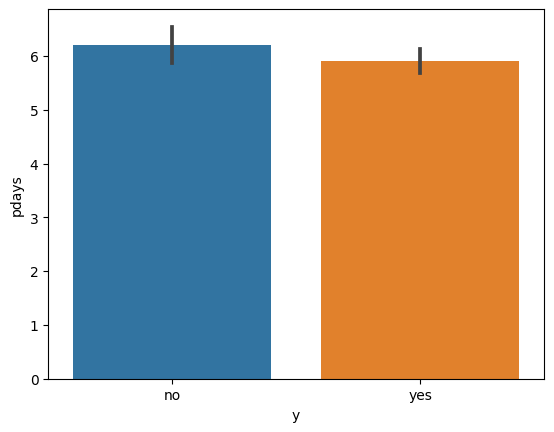

In [85]:
sns.barplot(data=df_aux, x="y", y="pdays")

<AxesSubplot:xlabel='y', ylabel='pdays'>

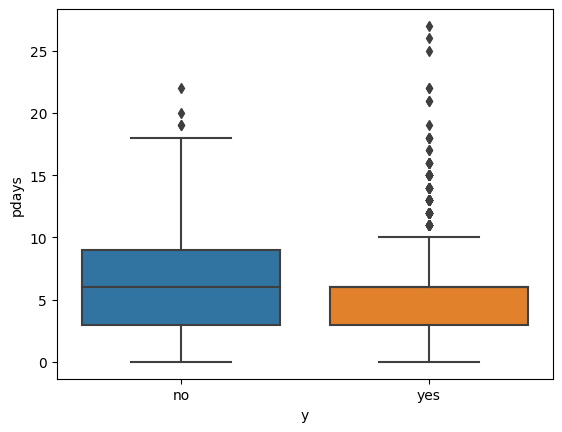

In [86]:
sns.boxplot(data=df_aux, x="y", y="pdays")

We can see that no subscribers tend to last more days since the last call to be calld again.

### Previous

Meaning: number of contacts performed before this campaign and for this client

In [87]:
df["previous"].value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

In [88]:
df.groupby("y")["previous"].mean()

y
no    0.132
yes   0.493
Name: previous, dtype: float64

In [89]:
df_aux = df.groupby(["previous"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="previous", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,previous,no,yes
0,0,32422.000,3141.000
1,1,3594.000,967.000
2,2,404.000,350.000
3,3,88.000,128.000
4,4,32.000,38.000


<AxesSubplot:xlabel='previous'>

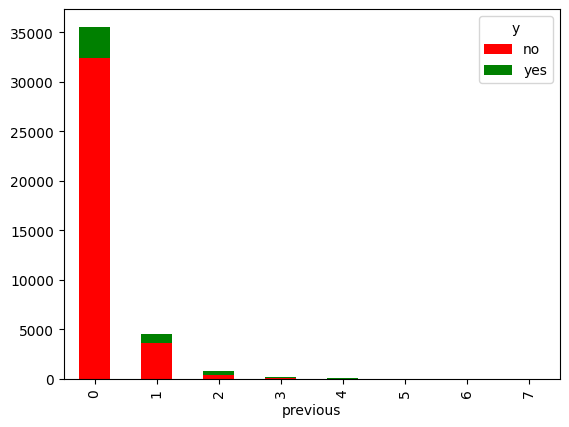

In [90]:
df_plot.plot(kind='bar', x="previous", stacked=True, color=['red', 'green'])

In [91]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["previous", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False).fillna(0)

y,previous,no,yes,%yes
5,5,5.000,13.000,0.722
6,6,2.000,3.000,0.600
3,3,88.000,128.000,0.593
4,4,32.000,38.000,0.543
2,2,404.000,350.000,0.464
1,1,3594.000,967.000,0.212
0,0,32422.000,3141.000,0.088
7,7,1.000,0.000,0.000


We see that after being called 1x, 2x, 3x we have a high percentage (>20%) of subscription, far better from no recall.

### Previous marketing campaign

Meaning: outcome of the previous marketing campaign

In [92]:
df["poutcome"].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [93]:
df_aux = df.groupby(["poutcome"])["y"].value_counts().rename("counts").to_frame().reset_index()
df_plot = pd.pivot_table(df_aux, values="counts", index="poutcome", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,poutcome,no,yes
0,failure,3647,605
1,nonexistent,32422,3141
2,success,479,894


<AxesSubplot:xlabel='poutcome'>

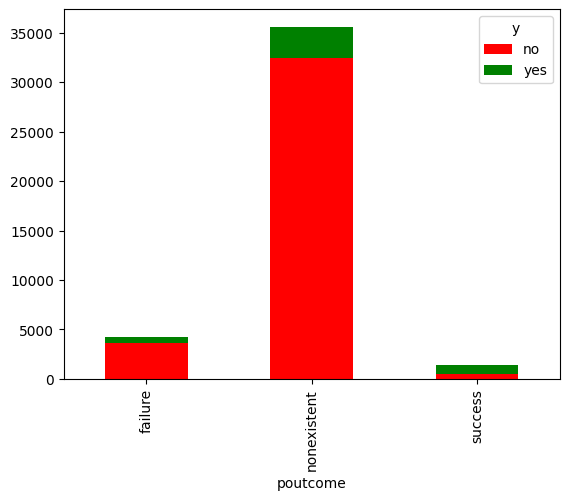

In [94]:
df_plot.plot(kind='bar', x="poutcome", stacked=True, color=['red', 'green'])

In [95]:
df_plot["%yes"] = df_plot["yes"] / (df_plot["yes"] + df_plot["no"])
df_plot[["poutcome", "no", "yes", "%yes"]].sort_values(by="%yes", ascending=False).fillna(0)

y,poutcome,no,yes,%yes
2,success,479,894,0.651
0,failure,3647,605,0.142
1,nonexistent,32422,3141,0.088


Having success in the last campaign seems like an important feature!

### 2.4 Social and economic context attributes

### Employment variation rate

Quarterly indicator, that is, the same each 3 months.

In [96]:
df["emp.var.rate"].value_counts()

1.400     16234
-1.800     9184
1.100      7763
-0.100     3683
-2.900     1663
-3.400     1071
-1.700      773
-1.100      635
-3.000      172
-0.200       10
Name: emp.var.rate, dtype: int64

In [97]:
df.groupby("y")["emp.var.rate"].mean()

y
no     0.249
yes   -1.233
Name: emp.var.rate, dtype: float64

In [98]:
df.groupby(["anomes"])["emp.var.rate"].value_counts()

anomes  emp.var.rate
200805  1.100           7763
200806  1.400           4374
200807  1.400           6685
200808  1.400           5175
200810  -0.100            67
200811  -0.100          3616
200812  -0.200            10
200903  -1.800           282
200904  -1.800          2458
200905  -1.800          5794
200906  -2.900           715
200907  -2.900           178
200908  -2.900           770
200909  -3.400           267
200910  -3.400           447
200911  -3.400           357
200912  -3.000           172
201003  -1.800           264
201004  -1.800           174
201005  -1.800           212
201006  -1.700           229
201007  -1.700           311
201008  -1.700           233
201009  -1.100           303
201010  -1.100           204
201011  -1.100           128
Name: emp.var.rate, dtype: int64

In [99]:
df_aux = df.copy()
df_aux["data"] = df_aux["anomes"].apply(lambda x : datetime.strptime(str(x), '%Y%m'))
df_aux = df_aux[["anomes", "emp.var.rate"]].drop_duplicates()
df_aux.head()

,anomes,emp.var.rate
0,200805,1.100
7763,200806,1.400
12137,200807,1.400
18822,200808,1.400
23997,200810,-0.100


Text(0.5, 1.0, 'Employment variation rate per month')

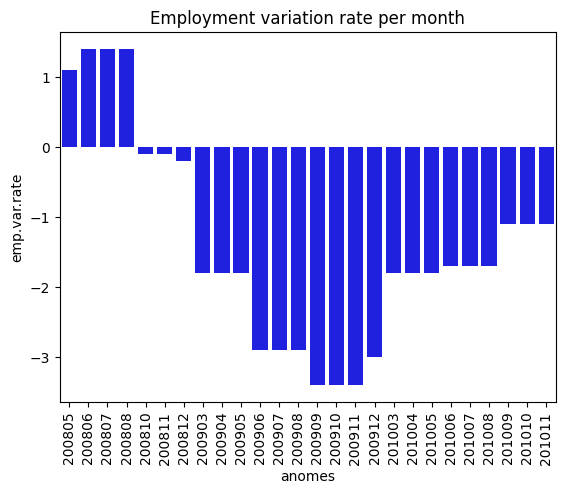

In [100]:
plt.xticks(rotation=90)
sns.barplot(data=df_aux, x="anomes", y="emp.var.rate", color="blue").set_title("Employment variation rate per month")

<AxesSubplot:xlabel='y', ylabel='emp.var.rate'>

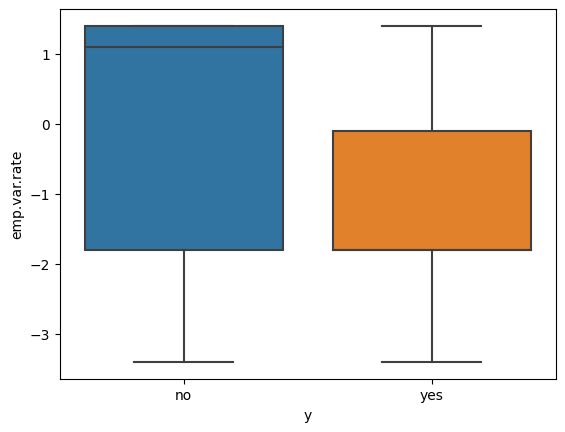

In [101]:
sns.boxplot(data=df, x="y", y="emp.var.rate")

It's a seasonal indicator. It seems like it discrimiates the subscription.

### Consumer confidence index

Monthly indicator.

In [102]:
df["cons.conf.idx"].value_counts()

-36.400    7763
-42.700    6685
-46.200    5794
-36.100    5175
-41.800    4374
-42.000    3616
-47.100    2458
-31.400     770
-40.800     715
-26.900     447
-30.100     357
-40.300     311
-37.500     303
-50.000     282
-29.800     267
-34.800     264
-38.300     233
-39.800     229
-40.000     212
-49.500     204
-33.600     178
-34.600     174
-33.000     172
-50.800     128
-40.400      67
-45.900      10
Name: cons.conf.idx, dtype: int64

In [103]:
df.groupby("y")["cons.conf.idx"].mean()

y
no    -40.593
yes   -39.790
Name: cons.conf.idx, dtype: float64

In [104]:
df.groupby(["anomes"])["cons.conf.idx"].value_counts()

anomes  cons.conf.idx
200805  -36.400          7763
200806  -41.800          4374
200807  -42.700          6685
200808  -36.100          5175
200810  -40.400            67
200811  -42.000          3616
200812  -45.900            10
200903  -50.000           282
200904  -47.100          2458
200905  -46.200          5794
200906  -40.800           715
200907  -33.600           178
200908  -31.400           770
200909  -29.800           267
200910  -26.900           447
200911  -30.100           357
200912  -33.000           172
201003  -34.800           264
201004  -34.600           174
201005  -40.000           212
201006  -39.800           229
201007  -40.300           311
201008  -38.300           233
201009  -37.500           303
201010  -49.500           204
201011  -50.800           128
Name: cons.conf.idx, dtype: int64

In [105]:
df_aux = df.copy()
df_aux["data"] = df_aux["anomes"].apply(lambda x : datetime.strptime(str(x), '%Y%m'))
df_aux = df_aux[["anomes", "cons.conf.idx"]].drop_duplicates()
df_aux.head()

,anomes,cons.conf.idx
0,200805,-36.400
7763,200806,-41.800
12137,200807,-42.700
18822,200808,-36.100
23997,200810,-40.400


Text(0.5, 1.0, 'Consumer confidence index')

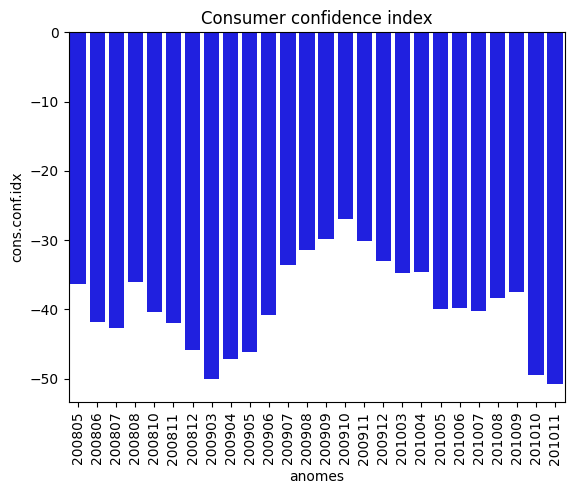

In [106]:
plt.xticks(rotation=90)
sns.barplot(data=df_aux, x="anomes", y="cons.conf.idx", color="blue").set_title("Consumer confidence index")

<AxesSubplot:xlabel='y', ylabel='cons.conf.idx'>

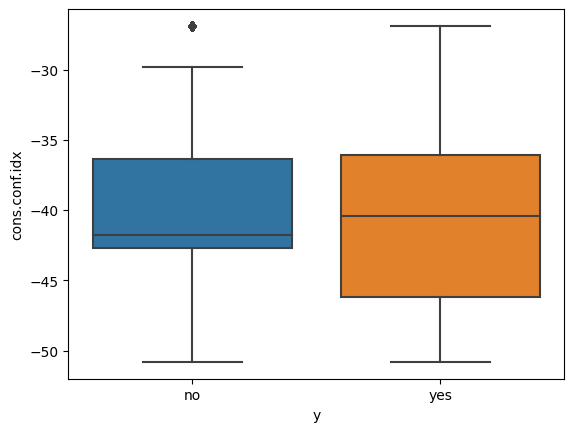

In [107]:
sns.boxplot(data=df, x="y", y="cons.conf.idx")

It's a seasonal indicator. It seems like it doesn't discrimiate the subscription.

### Consumer price index

Monthly indicator.

In [108]:
df["cons.price.idx"].value_counts()

93.994    7763
93.918    6685
92.893    5794
93.444    5175
94.465    4374
93.200    3616
93.075    2458
92.201     770
92.963     715
92.431     447
92.649     357
94.215     311
94.199     303
92.843     282
92.379     267
93.369     264
94.027     233
94.055     229
93.876     212
94.601     204
92.469     178
93.749     174
92.713     172
94.767     128
93.798      67
92.756      10
Name: cons.price.idx, dtype: int64

In [109]:
df.groupby("y")["cons.price.idx"].mean()

y
no    93.604
yes   93.354
Name: cons.price.idx, dtype: float64

In [110]:
df.groupby(["anomes"])["cons.price.idx"].value_counts()

anomes  cons.price.idx
200805  93.994            7763
200806  94.465            4374
200807  93.918            6685
200808  93.444            5175
200810  93.798              67
200811  93.200            3616
200812  92.756              10
200903  92.843             282
200904  93.075            2458
200905  92.893            5794
200906  92.963             715
200907  92.469             178
200908  92.201             770
200909  92.379             267
200910  92.431             447
200911  92.649             357
200912  92.713             172
201003  93.369             264
201004  93.749             174
201005  93.876             212
201006  94.055             229
201007  94.215             311
201008  94.027             233
201009  94.199             303
201010  94.601             204
201011  94.767             128
Name: cons.price.idx, dtype: int64

In [111]:
df_aux = df.copy()
df_aux["data"] = df_aux["anomes"].apply(lambda x : datetime.strptime(str(x), '%Y%m'))
df_aux = df_aux[["anomes", "cons.price.idx"]].drop_duplicates()
df_aux.head()

,anomes,cons.price.idx
0,200805,93.994
7763,200806,94.465
12137,200807,93.918
18822,200808,93.444
23997,200810,93.798


Text(0.5, 1.0, 'Consumer price index')

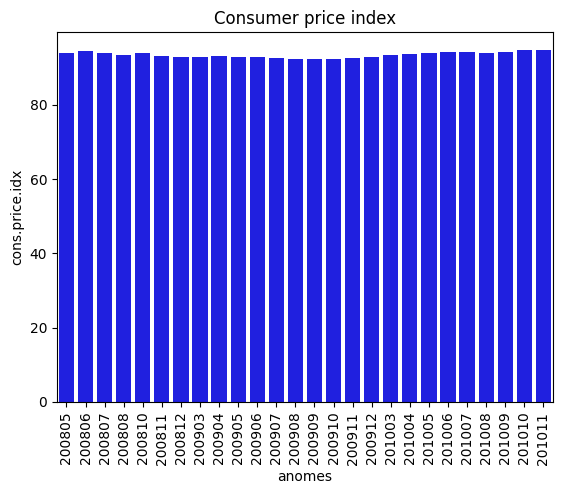

In [112]:
plt.xticks(rotation=90)
sns.barplot(data=df_aux, x="anomes", y="cons.price.idx", color="blue").set_title("Consumer price index")

<AxesSubplot:xlabel='y', ylabel='cons.price.idx'>

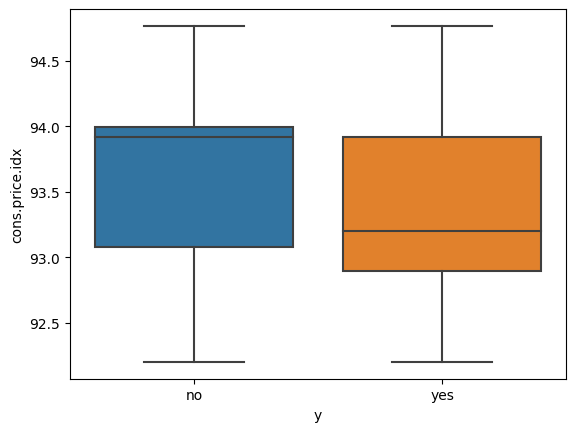

In [113]:
sns.boxplot(data=df, x="y", y="cons.price.idx")

It's a seasonal indicator. It seems like it discrimiates the subscription.

### Euribor 3 month rate

Daily indicator.

_Euribor is short for Euro Interbank Offered Rate. The Euribor rates are based on the interest rates at which a panel of European banks borrow funds from one another. In the calculation, the highest and lowest 15% of all the quotes collected are eliminated._

_The Euribor rates are important because these rates provide the basis for the price or interest rate of all kinds of financial products, like interest rate swaps, interest rate futures, saving accounts and mortgages._

_Since the Euribor rates are based upon agreements between many European banks, the level of the rates is determined by supply and demand in the first place. However there are some external factors, like economic growth and inflation which do influence the level of the rates as well._ (https://www.euribor-rates.eu/en/what-is-euribor/)

=> approximately CDI in Brazil (taxa média de juros praticada nos certificados interbancários de todo o mercado financeiro. Essa taxa, divulgada diariamente, é conhecida como “taxa DI” (também chamada de “taxa do CDI”) (https://www.infomoney.com.br/guias/cdi/))

In [107]:
df.groupby("y")["euribor3m"].mean()

y
no     46.503
yes   271.248
Name: euribor3m, dtype: float64

In [108]:
df.groupby(["anomes"])["euribor3m"].mean()

anomes
200805     4.858
200806     4.932
200807     4.962
200808     4.965
200810     4.924
200811     4.115
200812     3.493
200903     1.646
200904     1.412
200905     1.294
200906     1.258
200907   187.967
200908   866.087
200909   705.789
200910   588.127
200911   671.817
200912   609.080
201003   616.791
201004   608.801
201005   676.505
201006   657.604
201007   687.767
201008   764.435
201009   822.296
201010   549.510
201011     1.042
Name: euribor3m, dtype: float64

In [109]:
df_aux = df.copy()
df_aux["data"] = df_aux["anomes"].apply(lambda x : datetime.strptime(str(x), '%Y%m'))
df_aux = df.groupby(["anomes"])["euribor3m"].mean().to_frame().reset_index()
df_aux.head()

,anomes,euribor3m
0,200805,4.858
1,200806,4.932
2,200807,4.962
3,200808,4.965
4,200810,4.924


Text(0.5, 1.0, 'Euribor 3 month rate (average per month)')

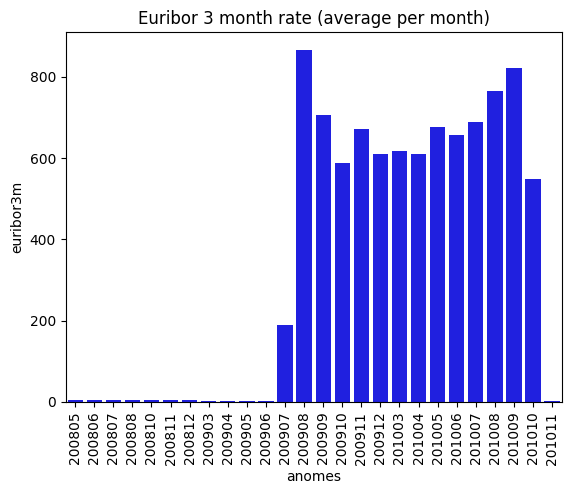

In [110]:
plt.xticks(rotation=90)
sns.barplot(data=df_aux, x="anomes", y="euribor3m", color="blue").set_title("Euribor 3 month rate (average per month)")

<AxesSubplot:xlabel='y', ylabel='euribor3m'>

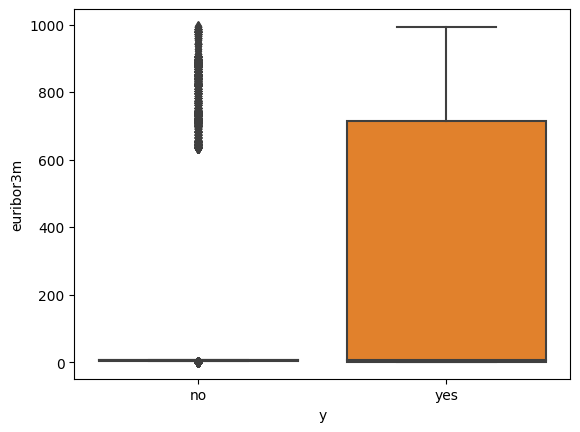

In [111]:
sns.boxplot(data=df, x="y", y="euribor3m")

It's a seasonal indicator. It seems like it discrimiates the subscription.

### Number of employees

Quarterly indicator.

In [112]:
df.groupby("y")["nr.employed"].mean()

y
no    5176.167
yes   5095.116
Name: nr.employed, dtype: float64

In [113]:
df.groupby(["anomes"])["nr.employed"].mean()

anomes
200805   5191.000
200806   5228.100
200807   5228.100
200808   5228.100
200810   5195.800
200811   5195.800
200812   5176.300
200903   5099.100
200904   5099.100
200905   5099.100
200906   5076.200
200907   5076.200
200908   5076.200
200909   5017.500
200910   5017.500
200911   5017.500
200912   5023.500
201003   5008.700
201004   5008.700
201005   5008.700
201006   4991.600
201007   4991.600
201008   4991.600
201009   4963.600
201010   4963.600
201011   4963.600
Name: nr.employed, dtype: float64

In [114]:
df_aux = df.copy()
df_aux["data"] = df_aux["anomes"].apply(lambda x : datetime.strptime(str(x), '%Y%m'))
df_aux = df.groupby(["anomes"])["nr.employed"].mean().to_frame().reset_index()
df_aux.head()

,anomes,nr.employed
0,200805,5191.000
1,200806,5228.100
2,200807,5228.100
3,200808,5228.100
4,200810,5195.800


Text(0.5, 1.0, 'Number of employees (per month)')

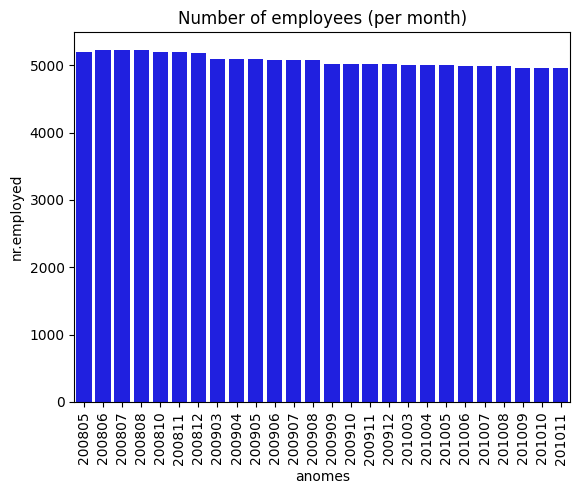

In [115]:
plt.xticks(rotation=90)
sns.barplot(data=df_aux, x="anomes", y="nr.employed", color="blue").set_title("Number of employees (per month)")

<AxesSubplot:xlabel='y', ylabel='nr.employed'>

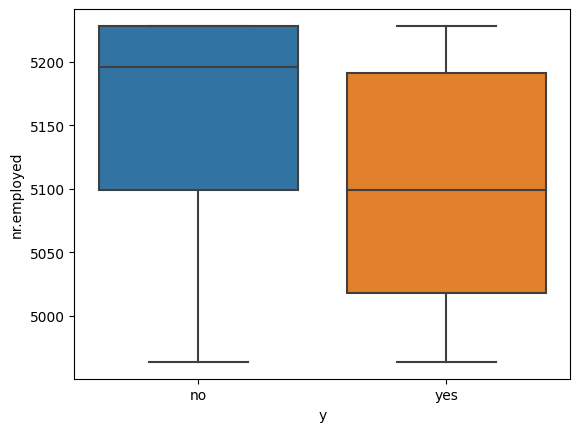

In [116]:
sns.boxplot(data=df, x="y", y="nr.employed")

It's a seasonal indicator. It seems like it discrimiates the subscription.

## 3. Correlation analysis

In [336]:
df = pd.read_csv(os.path.join(DATA_PATH, "bank-additional-full.csv"), sep=";")

### 3.1 Data Prep

First of all, let's prepare the data, so as to compute the correlation with the target variable.

In [337]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
1,57,services,married,high.school,unknown,no,no,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
2,37,services,married,high.school,no,yes,no,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
4,56,services,married,high.school,no,no,yes,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no


In [338]:
df["job"].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [339]:
enc_job = df["job"].str.get_dummies()
enc_job.columns = "job_" + enc_job.columns
df = pd.concat([df, enc_job], axis=1)
df = df.drop(columns=["job"]) # "job_unknown"
df.head()

,age,marital,education,default,housing,loan,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,56,married,basic.4y,no,no,no,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0
1,57,married,high.school,unknown,no,no,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0
2,37,married,high.school,no,yes,no,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0
3,40,married,basic.6y,no,no,no,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0
4,56,married,high.school,no,no,yes,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0


In [340]:
df["marital"].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [341]:
enc_marital = df["marital"].str.get_dummies()
enc_marital.columns = "marital_" + enc_marital.columns
df = pd.concat([df, enc_marital], axis=1)
df = df.drop(columns=["marital"]) # "marital_unknown"
df.head()

,age,education,default,housing,loan,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown
0,56,basic.4y,no,no,no,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,57,high.school,unknown,no,no,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,37,high.school,no,yes,no,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,40,basic.6y,no,no,no,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,56,high.school,no,no,yes,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [342]:
def transform_yes_no_column(default):
    default_value = -1.0
    if default == "yes":
        default_value = 1.0
    else: # "no" or "unknown"
        default_value = 0.0
    return default_value

def transform_contact(contact):
    contact_value = -1.0
    if contact == "cellular":
        contact_value = 1.0
    else: # "no" or "unknown"
        contact_value = 0.0
    return contact_value

def transform_poutcome(poutcome):
    poutcome_value = -1.0
    if poutcome == "success":
        poutcome_value = 1.0
    else: # "no" or "unknown"
        poutcome_value = 0.0
    return poutcome_value

def transform_education(education):
    school_order = {
        "illiterate":1,
        "basic.4y":2,
        "basic.6y":3,
        "basic.9y":4,
        "unknown":4, # i'll "average" the unknowns to Basic 9 years
        "professional.course":5, # i'll consider as the same level as High School
        "high.school":5,
        "university.degree":6
    }
    return school_order[education]

In [343]:
df["education"].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [344]:
df["education"] = df["education"].apply(transform_education)

In [345]:
df["education"].value_counts().sort_index(ascending=False)

6    12168
5    14758
4     7776
3     2292
2     4176
1       18
Name: education, dtype: int64

In [346]:
df["default"].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [347]:
#df["default"] = df["default"].apply(transform_yes_no_column)
enc_default = df["default"].str.get_dummies()
enc_default.columns = "default_" + enc_default.columns
df = pd.concat([df, enc_default], axis=1)
df = df.drop(columns=["default"])
df.head()

,age,education,housing,loan,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes
0,56,2,no,no,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,57,5,no,no,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,37,5,yes,no,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,40,3,no,no,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,56,5,no,yes,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [348]:
df["housing"].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [349]:
#df["housing"] = df["housing"].apply(transform_yes_no_column)
enc_housing = df["housing"].str.get_dummies()
enc_housing.columns = "housing_" + enc_housing.columns
df = pd.concat([df, enc_housing], axis=1)
df = df.drop(columns=["housing"])
df.head()

,age,education,loan,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes
0,56,2,no,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,57,5,no,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,37,5,no,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3,40,3,no,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,56,5,yes,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [350]:
df["loan"].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [351]:
#df["loan"] = df["loan"].apply(transform_yes_no_column)
enc_loan = df["loan"].str.get_dummies()
enc_loan.columns = "loan_" + enc_loan.columns
df = pd.concat([df, enc_loan], axis=1)
df = df.drop(columns=["loan"])
df.head()

,age,education,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,56,2,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,57,5,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0
2,37,5,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0
3,40,3,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,56,5,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1


In [352]:
df["contact"].value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

In [353]:
#df["contact"] = df["contact"].apply(transform_contact)
enc_contact = df["contact"].str.get_dummies()
enc_contact.columns = "contact_" + enc_contact.columns
df = pd.concat([df, enc_contact], axis=1)
df = df.drop(columns=["contact"])
df.head()

,age,education,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone
0,56,2,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
1,57,5,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1
2,37,5,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1
3,40,3,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
4,56,5,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1


In [354]:
#df = df.rename(columns={"contact":"contacted_by_cellular"})

In [355]:
#df["contacted_by_cellular"].value_counts()

In [356]:
# Cria o anomes
df["month_nb"] = df["month"].apply(lambda x : strptime(x,'%b').tm_mon)
df["anomes"] = (df["year"].astype(str) + df["month_nb"].astype(str).str.zfill(2)).astype(int)

In [357]:
enc_month = df["month"].str.get_dummies()
enc_month.columns = "month_" + enc_month.columns
df = pd.concat([df, enc_month], axis=1)
df = df.drop(columns=["month"]) # "month_dec"
df.head()

,age,education,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_nb,anomes,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,56,2,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0
1,57,5,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0
2,37,5,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0
3,40,3,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0
4,56,5,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,5,200805,0,0,0,0,0,0,1,0,0,0


In [358]:
#df = df.drop(columns=["year"])

In [359]:
enc_dow = df["day_of_week"].str.get_dummies()
enc_dow.columns = "day_of_week_" + enc_dow.columns
df = pd.concat([df, enc_dow], axis=1)
df = df.drop(columns=["day_of_week"]) # "day_of_week_thu"
df.head()

,age,education,year,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_nb,anomes,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,2,2008,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,57,5,2008,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,37,5,2008,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,40,3,2008,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,56,5,2008,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [360]:
df["poutcome"].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [361]:
#df["poutcome"] = df["poutcome"].apply(transform_poutcome)
enc_poutcome = df["poutcome"].str.get_dummies()
enc_poutcome.columns = "poutcome_" + enc_poutcome.columns
df = pd.concat([df, enc_poutcome], axis=1)
df = df.drop(columns=["poutcome"])
df.head()

,age,education,year,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_nb,anomes,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,2,2008,261,1,999,0,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,5,2008,149,1,999,0,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,5,2008,226,1,999,0,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,3,2008,151,1,999,0,1.100,93.994,-36.400,4.857,5191.000,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,5,2008,307,1,999,0,1.100,93.994,-36.400,4.857,5191.000,no,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,5,200805,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [362]:
df["y"].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [363]:
df["y"] = df["y"].apply(transform_yes_no_column)

In [364]:
df["y"].value_counts()

0.000    36548
1.000     4640
Name: y, dtype: int64

### 3.2 Compute the correlations

* Correlations with the target

In [365]:
df.corr()["y"].sort_values(ascending=False)

y                       1.000
duration                0.405
anomes                  0.352
year                    0.348
euribor3m               0.319
poutcome_success        0.316
previous                0.230
contact_cellular        0.145
month_mar               0.144
month_oct               0.137
month_sep               0.126
default_no              0.099
job_student             0.094
job_retired             0.092
month_dec               0.079
month_apr               0.076
cons.conf.idx           0.055
marital_single          0.054
education               0.044
month_nb                0.037
poutcome_failure        0.032
job_admin.              0.031
age                     0.030
job_unemployed          0.015
day_of_week_thu         0.014
housing_yes             0.012
day_of_week_tue         0.008
day_of_week_wed         0.006
marital_unknown         0.005
loan_no                 0.005
job_unknown            -0.000
job_management         -0.000
housing_unknown        -0.002
loan_unkno

Conclusions:
- The variable `duration` is very correlated with subscription, however it cannot be used to predict the subscription, because we don't have it in the time of prediction, only after the call.
- Time variables like `anomes`, `year`, `month_`, `campaign` are difficult to analyse, because they are very unbalanced in terms of quantity of examples. As we saw, we have much more examples in the first months and year than we have in the last months.
- The index `euribor3m` is the Euribor rate. It is important because this rate provides the basis for the price or interest rate of all kinds of financial products, like interest rate swaps, interest rate futures, saving accounts and mortgages. We see high positive correlation, because high Euribor guarantees higher returns from the investment.
    - The index `emp.var.rate` is the employment variation rate. We see negative correlation with subscription, because in general high values of variation of employment lead to more incertainty in the market behaviour, and then less propension to subscxribe to an investment.
    - The index `cons.price.idx` is the CPI (inflation rate), and also with negative correlation with subscription. As written in (https://www.investopedia.com/terms/t/termdeposit.asp): _Unfortunately, term deposits do not keep up with inflation. The inflation rate is a measure of how much prices rise in a given year. If the rate on a term deposit is 2% and the inflation rate in the U.S. is 2.5%, theoretically, the customer is not earning enough to compensate for price increases in the economy._ So, when inflation is high, investors tend not to subscribe to term deposits.
    - The index `cons.conf.idx` is the CCI (Consumer confidence index): _This consumer confidence indicator provides an indication of future developments of households’ consumption and saving, based upon answers regarding their expected financial situation, their sentiment about the general economic situation, unemployment and capability of savings. (https://data.oecd.org/leadind/consumer-confidence-index-cci.htm)_. As we can see, higher confidence in the market indicates more subscriptions. 
- The variables measuring the quality of past campaigns `poutcome_success` is also important, meaning that if we had success with this client in past marketing campaigns, we may have success in future campaign calls as well (note as well the negative correlation with `poutcome_nonexistent`, and no correlation with `poutcome_failure`).
    - Also, it's worth noting that we have positive correlation with `previous` (which indicates how many were contacts performed before this campaign and for this client) and negative with `pdays` (number of days that passed by after the client was last contacted from a previous campaign), meaning that having previously contacted the client and timely recontancting lead to higher subscription rates.
- The contact type also seems to be relevant, as we get high correlation with `contact_cellular` and low correlation with `contact_telephone`. We may infer that the clients tend to subscribe more when contacted via cellular.
- Having no default is also important (`default_no`)
- Having no loans seems **not to be important** (`loan_no`)
- As we saw in the previous analysis, students and retired people have higher proportions of subscription, while administrators tend to have larger values of subscription (`job_student`, `job_retired`, `job_admin.`). We see that they have bigger correlations too. Also, we see that less intellectual jobs (blue collar) tend to subscribe less to this kind of investment. We see negative correlation with `job_blue-collar`.
- As we saw in the previous analysis, single people have higher proportions of subscription (`marital_single`). We see that they have bigger correlations too.
- We see that the educational backgroud seem to be important (`education`).
- We see that the number of employees presents very high negative correlation with subscribing (`nr.employed`). There's not much change in the number of employees as the time passes. Moreover, the quantity of employees is a business decision. It may seem that with less employees we have better subscription rates, but it deserves more detailed analysis on the reason of that (more efficiency in operation? the same operator recalls the client and converts more? etc.)